In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis/')
import analog
from analog import logextract as logextract

In [168]:
log_path = '/home/lucas/Documents/Log_Analysis/Logs'
log_index = '1'
log_file = analog.pathfromQGC(log_path,log_index)
print(log_file)

/home/lucas/Documents/Log_Analysis/Logs/log_103_2019-1-7-14-59-08.ulg


In [169]:
topic_list = ['battery_status']
info = logextract(log_file,topic_list)

In [170]:
time = info['time_bs']
n_cells = info['n_cells']
voltage_v = info['battery_filtered_voltage']
current_a = info['battery_current']
current_filtered_a = info['battery_filtered_current']
_discharged_mah = info['discharged_mah']
_remaining = info['remaining']

In [171]:
# Battery cell parameters
r_internal = 0.005 #Ohm
v_empty = 3.56 #V
v_charged = 4.15 #V
capacity_tot = 6500 #mAh
capacity = capacity_tot - _discharged_mah[0] #mAh

In [172]:
cell_voltage = voltage_v / n_cells # similar to Battery Voltage filtered in flight review
cell_voltage +=  r_internal * current_filtered_a

<IPython.core.display.Javascript object>


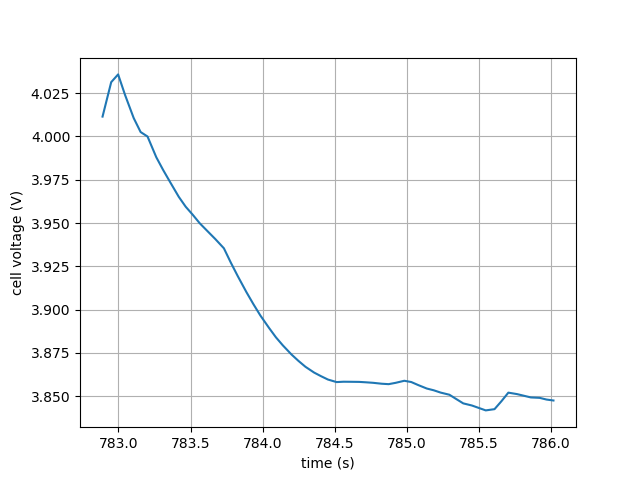

Text(0, 0.5, 'cell voltage (V)')

In [173]:
# Figure 1 : unfiltered voltage
plt.figure()
plt.plot(time,cell_voltage)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('cell voltage (V)')

<IPython.core.display.Javascript object>


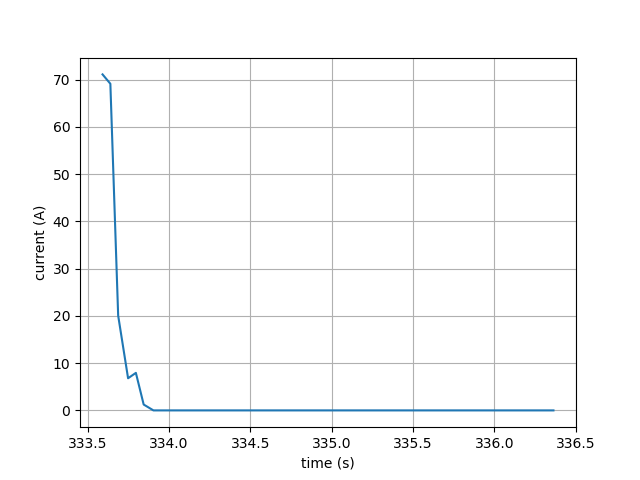

Text(0, 0.5, 'current (A)')

In [156]:
# Figure 2 : unfiltered current
plt.figure()
plt.plot(time,current_a)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('current (A)')

In [174]:
# remaining_voltage is NOT a voltage, it is the remaining percentage based on the voltage
remaining_voltage = (cell_voltage-v_empty)/(v_charged-v_empty)
remaining_voltage[np.nonzero(remaining_voltage < 0)] = 0
remaining_voltage[np.nonzero(remaining_voltage > 1)] = 1

In [175]:
# coulomb counting
dt = np.diff(time)
discharged_mah_loop = []
discharged_mah_loop.append(0)
for k in range(len(dt)):
    discharged_mah_loop.append(current_a[k+1]*1e3 * dt[k]/3600) # to bring it to mAh
    
discharged_mah = np.cumsum(discharged_mah_loop) + _discharged_mah[0]

In [176]:
current_a[1]*1e3 * (time[1]-time[0])/3600 #mAh

1.315732490693269

In [177]:
print(_discharged_mah[1])
print(discharged_mah[1])
print(_discharged_mah[-1])
print(discharged_mah[-1])
print(discharged_mah_loop[0])

2059.5723
2059.5295996781933
2075.565
2076.010655166693
0


<IPython.core.display.Javascript object>


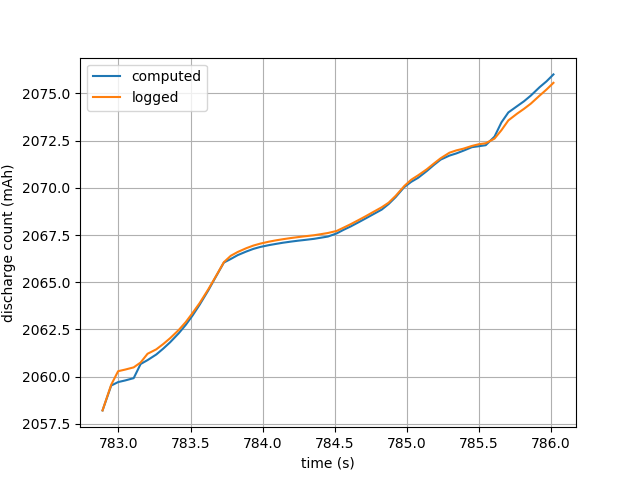

Text(0, 0.5, 'discharge count (mAh)')

In [178]:
# Figure 3 : Comparation between logged and computed coulomb counting 
plt.figure()
plt.plot(time,discharged_mah,label='computed')
plt.plot(time,_discharged_mah,label='logged')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('discharge count (mAh)')

In [93]:
print(_discharged_mah[0]-discharged_mah[0]) # verification, should be zero

0.0


In [179]:
remaining_current = np.array([_remaining[0]-discharged_mah/capacity_tot]).transpose()

<IPython.core.display.Javascript object>


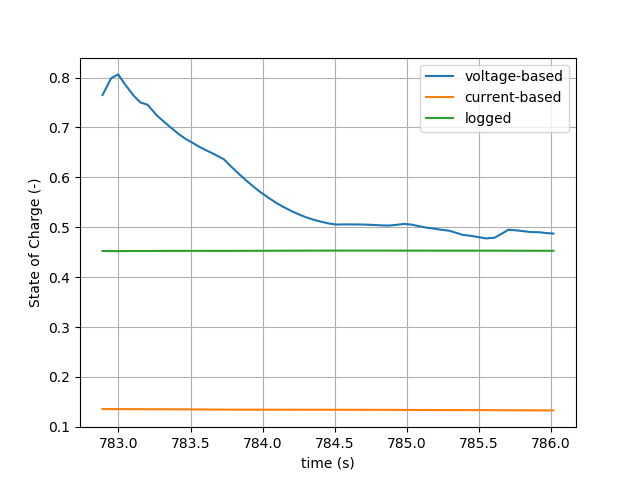

Text(0, 0.5, 'State of Charge (-)')

In [180]:
# Figure 4 : remaining charge assuming linear voltage decreasing
plt.figure()
plt.plot(time,remaining_voltage,label='voltage-based')
plt.plot(time,remaining_current,label='current-based')
plt.plot(time,_remaining,label='logged')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('State of Charge (-)')

In [96]:
print(_discharged_mah[-1]-_discharged_mah[-2])
print(discharged_mah_loop[-1])

0.0
0.0


### Now there is a kind of filtering step where the current-based estimation and the voltage-based estimation are balanced
this balance explains the difference between the two curves above

<IPython.core.display.Javascript object>


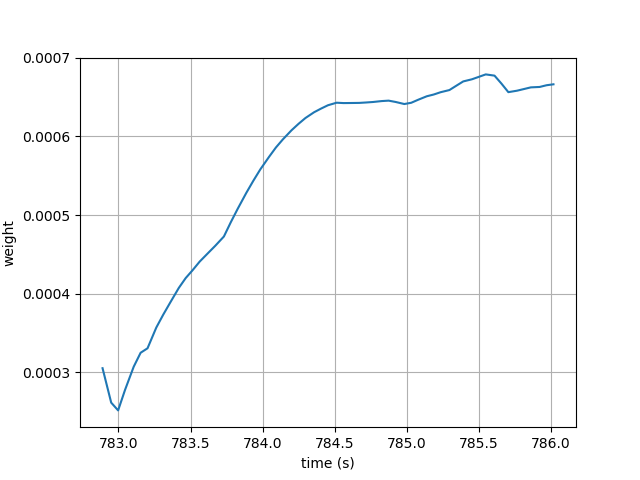

Text(0, 0.5, 'weight')

In [181]:
# weight for voltage/current weightning
# weight_v = 3e-4*(1-remaining_voltage)
weight_v = 1.3e-3*(1-remaining_voltage) # WHY THE HECK DOES IT WORK WITH THIS VALUE
plt.figure()
plt.plot(time,weight_v)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('weight')

In [182]:
remaining = []
remaining.append(_remaining[0]) # take the log first value 

# the first discharge_mah_loop is now zero
for k in range(len(discharged_mah_loop)-1): #discharged_mah_loop has one less value than the others
    weighted_remaining = (1-weight_v[k]) * remaining[k] + weight_v[k] * remaining_voltage[k]
    discharged_weighted_remaining = weighted_remaining - discharged_mah_loop[k]/capacity_tot
    remaining.append(np.max(discharged_weighted_remaining,0))

<IPython.core.display.Javascript object>


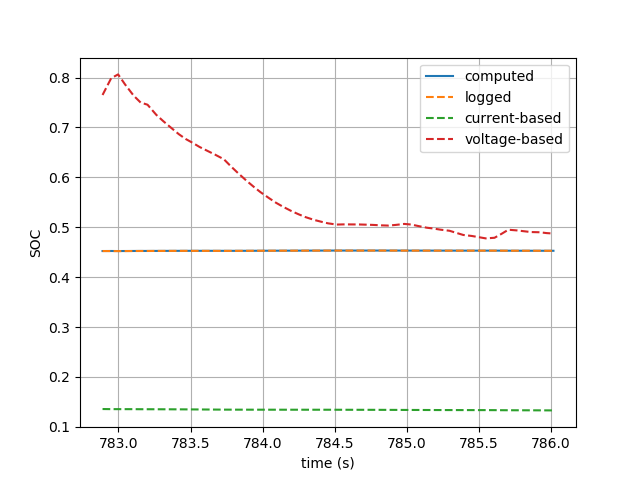

Text(0, 0.5, 'SOC')

In [183]:
# Figure 5 : remaining SOC
plt.figure()
plt.plot(time,remaining,label='computed')
plt.plot(time,_remaining,label='logged',linestyle='--')
plt.plot(time,remaining_current,label='current-based',linestyle='--')
plt.plot(time,remaining_voltage,label='voltage-based',linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('SOC')

In [ ]:
remaining-_remaining

# Testing with more accurate SOC = f(OCV) instead of gradual

In [106]:
import math
from scipy.interpolate import interp1d

In [107]:
# LMO assumed because of the empty voltage

a = 3.875
b = -0.335
c = -0.5332
d = 0.8315
m = 0.653
n = 0.6
SOC = np.linspace(0.01,1.4,100)
type(np.log(SOC))

numpy.ndarray

In [108]:
OCVfromSOC = a + b*np.power(-np.log(SOC),m) + c*SOC + d*np.exp(n*(SOC-1))

/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


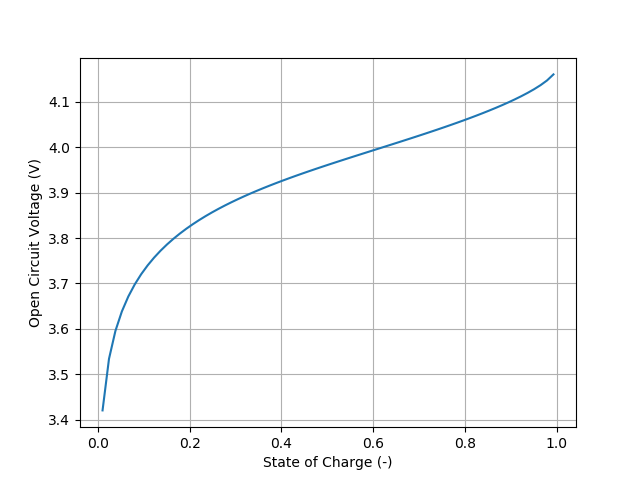

Text(0, 0.5, 'Open Circuit Voltage (V)')

In [109]:
plt.figure()
plt.plot(SOC,OCVfromSOC)
plt.grid()
plt.xlabel('State of Charge (-)')
plt.ylabel('Open Circuit Voltage (V)')

<IPython.core.display.Javascript object>


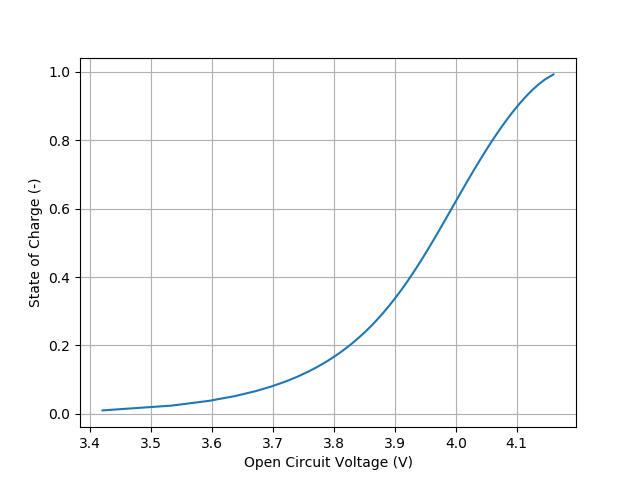

Text(0, 0.5, 'State of Charge (-)')

In [110]:
SOCfromOCV = interp1d(OCVfromSOC,SOC)
plt.figure()
plt.plot(OCVfromSOC,SOCfromOCV(OCVfromSOC))
plt.grid()
plt.xlabel('Open Circuit Voltage (V)')
plt.ylabel('State of Charge (-)')

In [ ]:
SOC_cell = SOCfromOCV(cell_voltage)
print(cell_voltage)
print(SOC_cell)

In [ ]:
plt.figure()
plt.plot(time,SOC_cell,label='model')
plt.plot(time,remaining_voltage, label='grad')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('State of Charge (-)')

In [111]:
newremaining = []
newremaining.append(_remaining[0])

# the first discharge_mah_loop is now zero
for k in range(1,len(discharged_mah_loop)): #discharged_mah_loop has one less value than the others
    newremaining.append((1-weight_v[k]) * newremaining[k-1] + weight_v[k] * SOC_cell[k])
    newremaining[k] -= discharged_mah_loop[k] / capacity_tot
    newremaining[k] = np.max(newremaining[k],0)

<IPython.core.display.Javascript object>


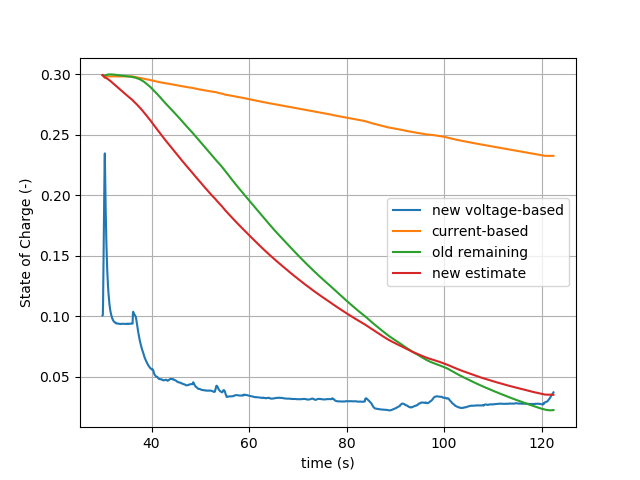

Text(0, 0.5, 'State of Charge (-)')

In [113]:
plt.figure()
plt.plot(time,SOC_cell,label='new voltage-based')
plt.plot(time,remaining_current,label='current-based')
plt.plot(time,remaining,label='old remaining')
plt.plot(time,newremaining,label='new estimate')
plt.legend()
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('State of Charge (-)')

In [ ]:
plt.figure()
plt.plot(time,_remaining,label="old")
plt.plot(time,newremaining,color='green',label="new")
plt.legend()
plt.grid()
plt.xlabel("time (s)")
plt.ylabel('State of Charge (-)')